In [1]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
from itertools import product
from turtle import shape
import pygad
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']   
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel('酶复配数据集.xlsx') 

data = data.drop_duplicates()


In [2]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

[0, 0]
[1, 1]
[2, 2]
[3, 3]
[4, 4]
[5, 5]
[6, 6]


<Axes: >

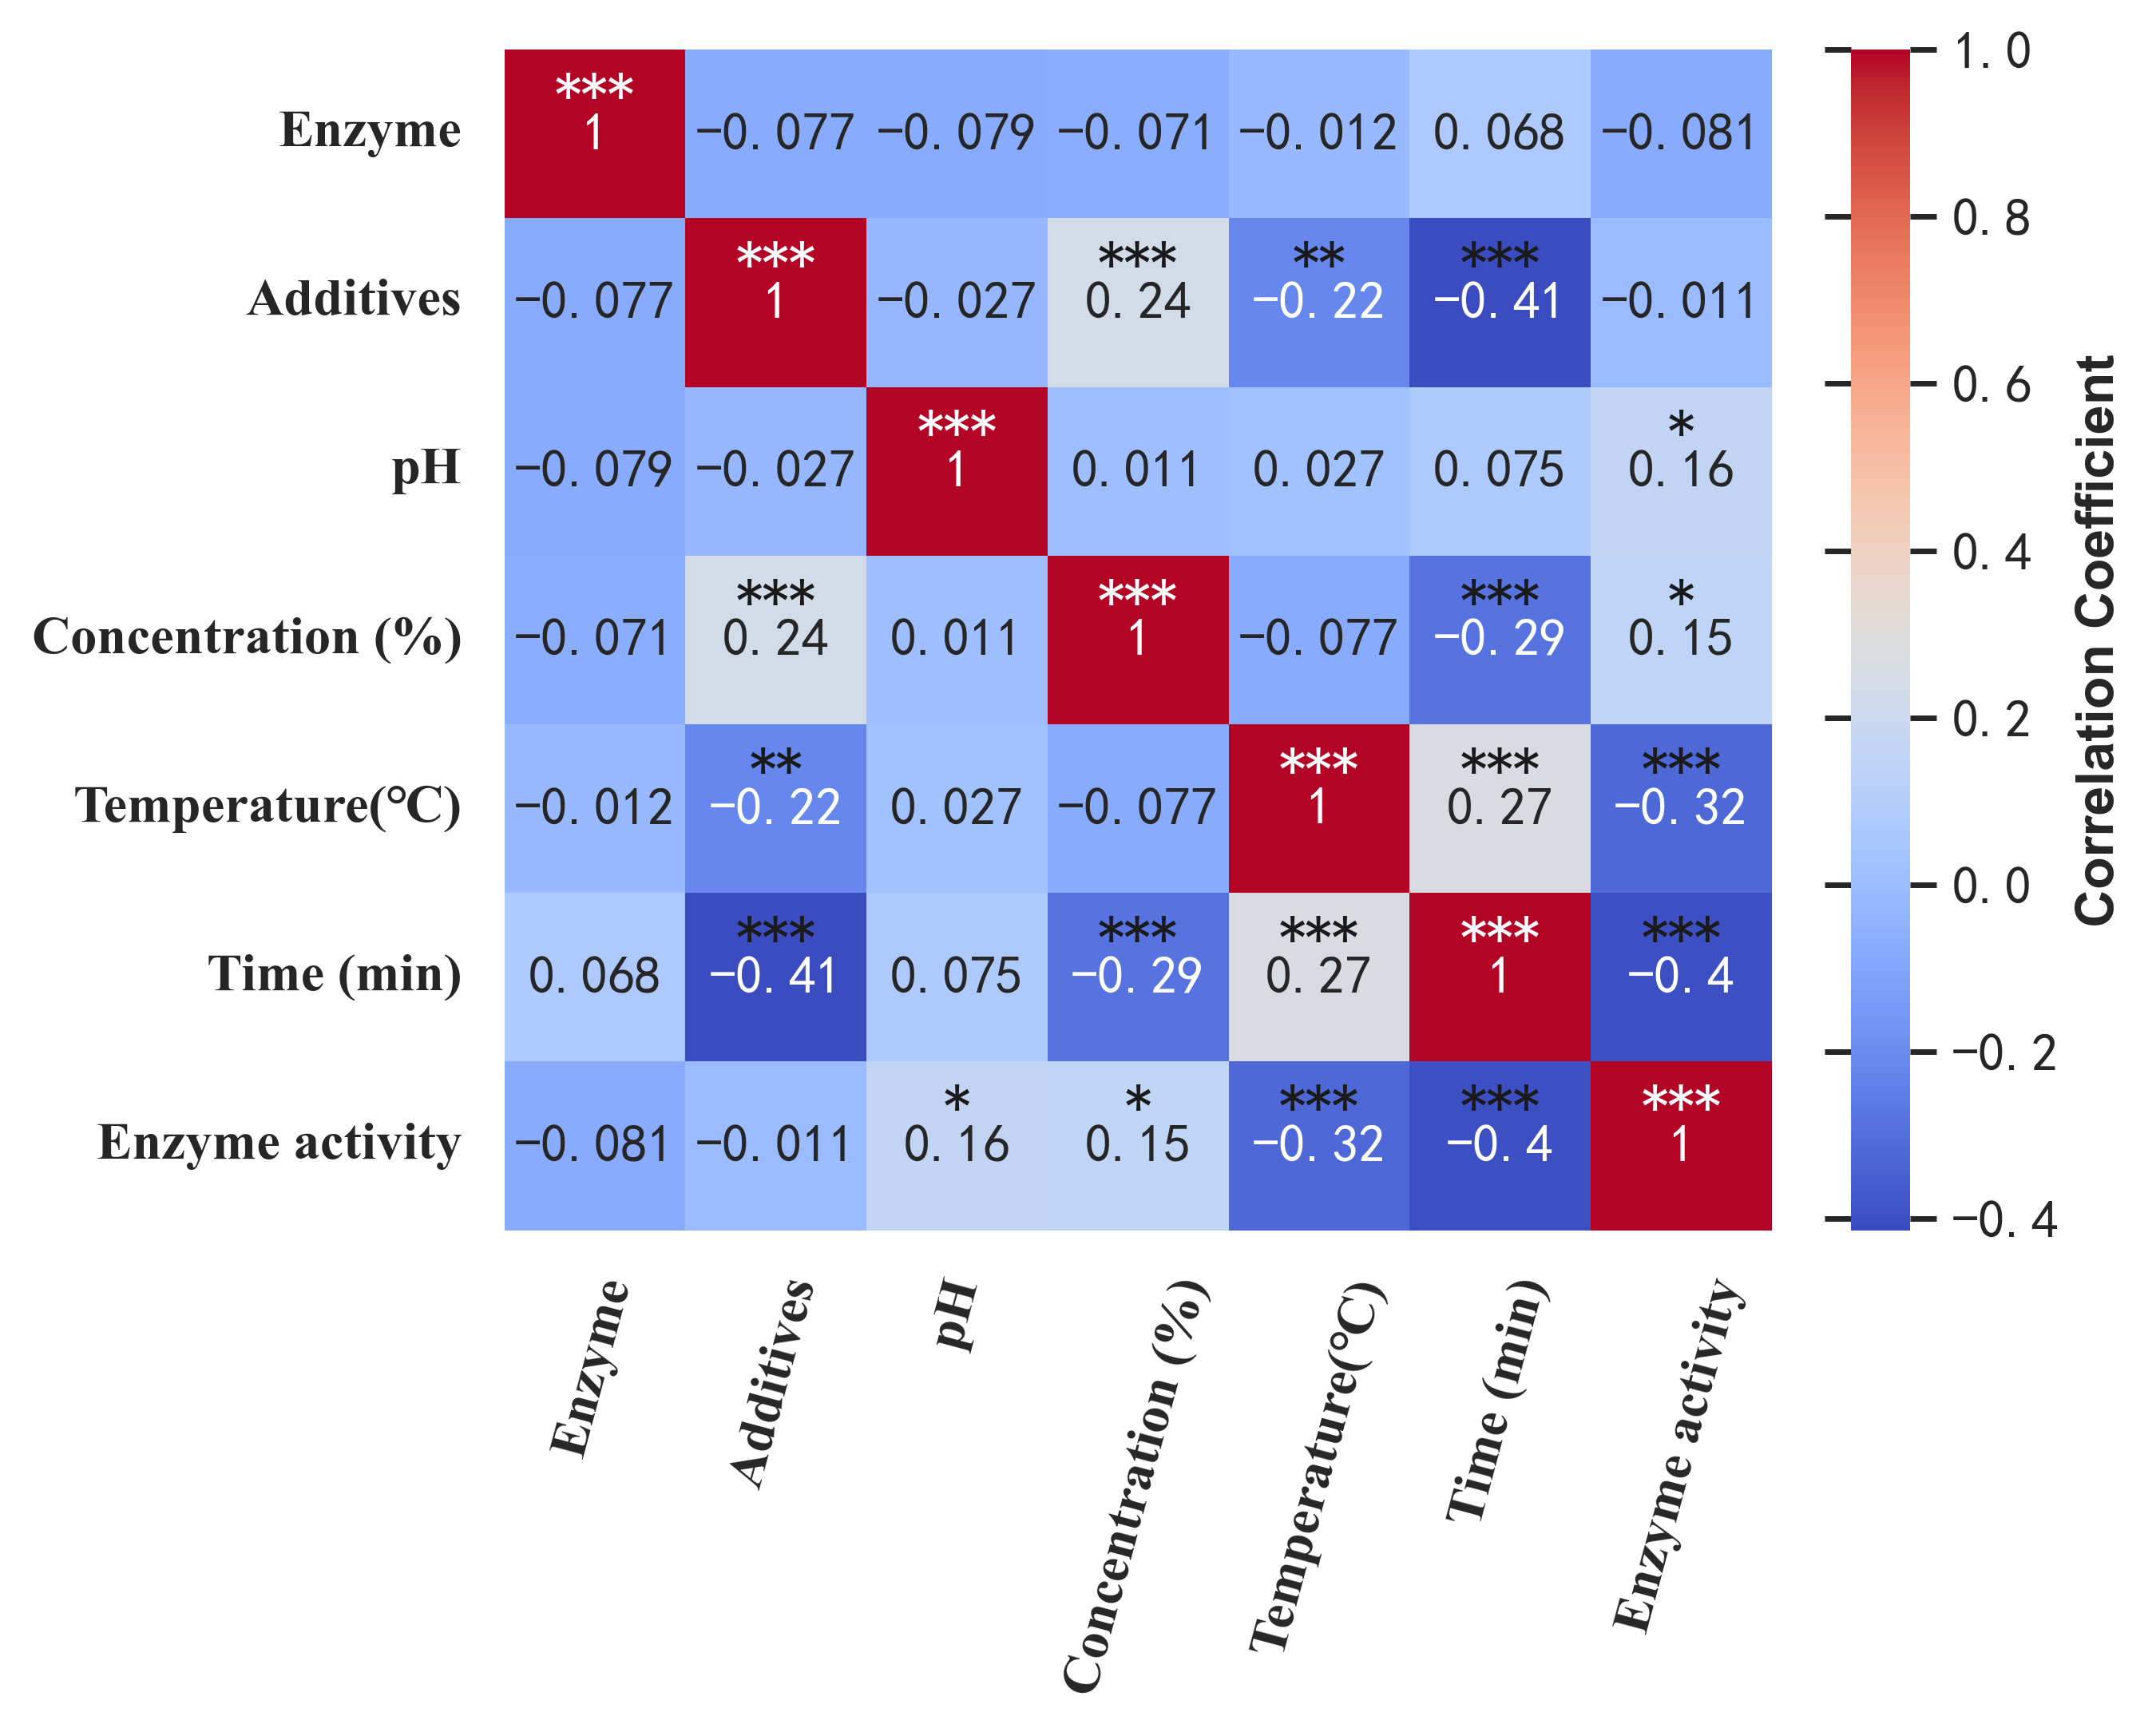

In [3]:
import scipy.stats as stats
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
sns.set(font='SimHei') 
data_2 = pd.read_excel('酶复配数据集.xlsx')
data_2['酶'] = label_encoder.fit_transform(data_2['酶'])
data_2['助剂'] = label_encoder.fit_transform(data_2['助剂'])
data_2 = data_2.rename(columns={'酶': 'Enzyme'})
data_2 = data_2.rename(columns={'助剂':'Additives'})
data_2 = data_2.rename(columns={'浓度':'Concentration (%)'})
data_2 = data_2.rename(columns={'孵育温度':'Temperature(℃)'})
data_2 = data_2.rename(columns={'孵育时间':'Time (min)'})
data_2 = data_2.rename(columns={'酶活':'Enzyme activity'})
features_all2 = data_2.corr()    
plt.figure(dpi=400)

mask = np.zeros_like(features_all2)
mask[np.triu_indices_from(mask)] = False
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)



ax = sns.heatmap(features_all2,cmap = 'coolwarm',annot =True)

rlist = []
plist = []
for i in data_2.columns.values:
    for j in data_2.columns.values:
        r,p = stats.pearsonr(data_2[i],data_2[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(data_2.columns.values),len(data_2.columns.values))
parr = np.asarray(plist).reshape(len(data_2.columns.values),len(data_2.columns.values))
xlist = ax.get_xticks()
ylist = ax.get_yticks()

widthx = 0
widthy = -0.15

for m in ax.get_xticks():
    for n in ax.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
                    
cbar = ax.collections[0].colorbar  
cbar.set_label('Correlation Coefficient', fontname='Arial',fontweight='bold')  
cbar.ax.tick_params(labelsize=12)    
cbar.ax.yaxis.set_ticks_position('both') 
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold',rotation=75)  
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold', )  
plt.savefig('SVR单酶预测热力图.jpg', dpi=600, bbox_inches='tight')
ax

In [23]:
x_ = data.drop(columns=['酶活'], axis=1)
y_ = data['酶活']
scaler = MinMaxScaler()
scaler.fit(x_) 
x_transfer = scaler.transform(x_) 
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_transfer,y_,test_size = 0.2,random_state = 55) 
original_column_names = x_.columns.tolist()
y_test_ = [v for idx, v in enumerate(y_test_, start=0)]  
x_test_restored = scaler.inverse_transform(x_test_)
x_test_restored = pd.DataFrame(x_test_restored)
x_test_restored.columns = original_column_names
x_test_restored.head()

,酶,助剂,pH,浓度,孵育温度,孵育时间
0,0.0,5.0,7.5,0.0001,40.0,10.0
1,2.0,1.0,7.5,0.0100,70.0,40.0
2,2.0,0.0,7.5,0.0100,50.0,40.0
3,0.0,9.0,7.5,0.0100,40.0,10.0
4,0.0,0.0,9.0,0.0100,50.0,20.0


In [30]:
svr = SVR()
param_grid={'C':[0.01,0.1,1,10,50,100,150],'epsilon':[0,0.001,0.01,0.1,1,10],'gamma':[0.01,0.1,1,10]}
svr_model_=GridSearchCV(svr,param_grid,cv=10)
svr_model_.fit(x_train_, y_train_)
print('SVR模型的最佳验证参数：\n', svr_model_.best_params_)

SVR模型的最佳验证参数：
 {'C': 1, 'epsilon': 0, 'gamma': 1}


In [31]:
pre1 = svr_model_.predict(x_train_)
pre2 = svr_model_.predict(x_test_)
R2_1 = r2_score(y_train_,pre1)
R2_2 = r2_score(y_test_,pre2)
print("train_model's R2: {:.4f}".format(R2_1))
print("test_model's R2: {:.4f}".format(R2_2))
mse_train_ = np.mean(np.power(y_train_ - pre1, 2))
mse_test_ = np.mean(np.power(y_test_ - pre2, 2))
print("train_model's MSE: {:.4f}".format(mse_train_))
print("test_model's MSE: {:.4f}".format(mse_test_))
print("train_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_train_,pre1)))
print("test_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_test_,pre2)))

train_model's R2: 0.6378
test_model's R2: 0.6028
train_model's MSE: 0.0454
test_model's MSE: 0.0538
train_model's RMSE: 0.21303384432019173
test_model's RMSE: 0.23203311491661033


In [32]:
pre_result = x_test_restored.copy() 
pre_result['实际酶活'] = y_test_
pre_result['预测酶活'] = pre2
pre_result

,酶,助剂,pH,浓度,孵育温度,孵育时间,实际酶活,预测酶活
0,0.0,5.0,7.5,0.0001,40.0,10.0,1.013815,1.039077
1,2.0,1.0,7.5,0.0100,70.0,40.0,0.525215,0.589642
2,2.0,0.0,7.5,0.0100,50.0,40.0,0.903419,0.830113
3,0.0,9.0,7.5,0.0100,40.0,10.0,1.022807,1.027195
4,0.0,0.0,9.0,0.0100,50.0,20.0,0.856000,1.157061
5,2.0,1.0,7.5,0.0002,70.0,40.0,0.787823,0.590593
6,1.0,8.0,6.0,0.0100,70.0,40.0,0.036556,0.555324
7,1.0,1.0,9.0,0.0010,30.0,30.0,1.354886,0.850666
8,2.0,4.0,7.5,0.0001,40.0,10.0,1.010000,1.018725
9,2.0,1.0,7.5,0.0100,50.0,20.0,0.752859,0.932949


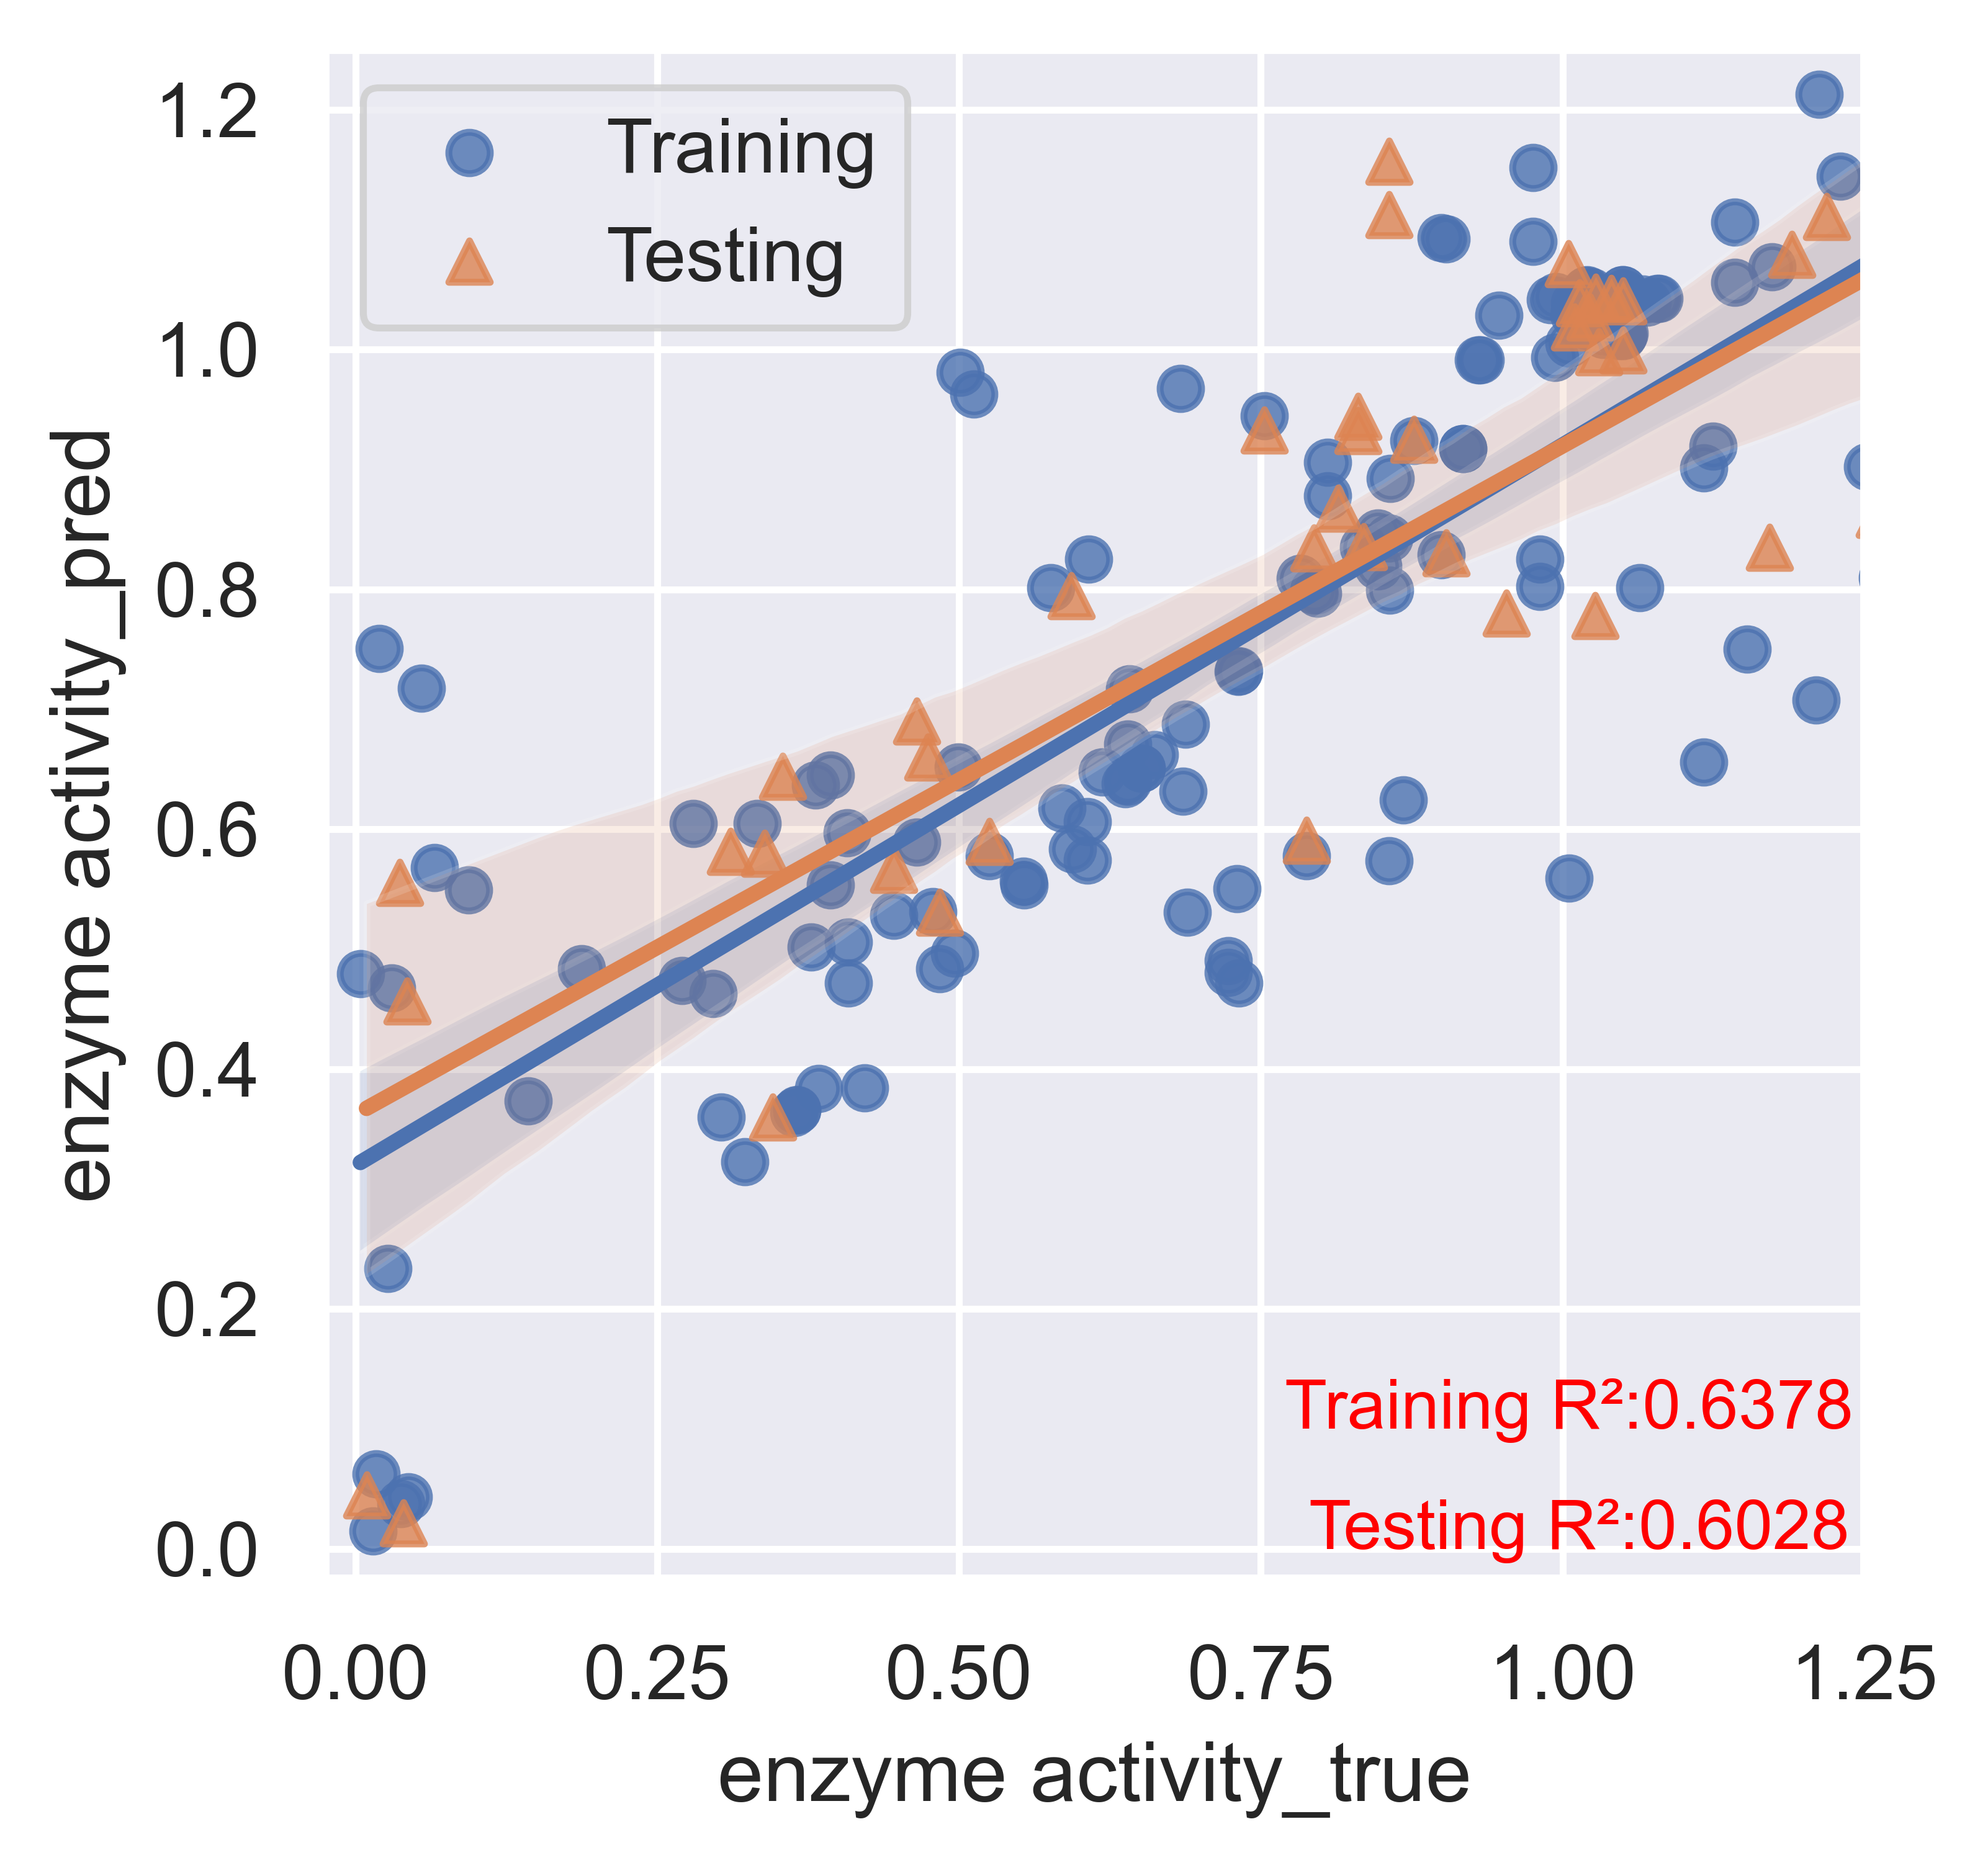

In [36]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

plt.figure(dpi=800, figsize=(4,4))
sns.set(font='SimHei')
sns.set(color_codes=True)

sns.regplot(x=y_train_,y=pre1, label='Training')
plt.legend(loc='upper left')

sns.regplot(x=y_test_,y=pre2,marker='^', label='Testing')
plt.legend(loc='upper left')

plt.xlim([-0.025, 1.25])   
plt.ylim([-0.025, 1.25]) 

plt.text(0.77, 0.1, 'Training R²:0.6378', fontsize=10, color='red')   
plt.text(0.79, 0, 'Testing R²:0.6028', fontsize=10, color='red')   
plt.xlabel('enzyme activity_true')  
plt.ylabel('enzyme activity_pred') 

plt.savefig('SVR单酶预测线性回归图.jpg', dpi=600, bbox_inches='tight')